In [ ]:
import numpy as np
np.random.randn(5)
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
nnfs.init()

In [ ]:
# Dense Layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs): 
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues): 
        self.dweights = np.dot(self.inputs.T, dvalues) 
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU
class Activation_ReLU:
    def forward(self, inputs): 
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues): 
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Sigmoid
class Activation_Sigmoid:
    def forward(self, inputs): 
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
    def backward(self, dvalues): 
        self.dinputs = dvalues * (1 - self.output) * self.output


In [ ]:
class Loss:
    def regularization_loss(self, layer): 
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def calculate(self, output, y): 
        sample_losses = self.forward(output, y)
        return np.mean(sample_losses)

class Loss_BinaryCrossentropy(Loss): 
    def forward(self, y_pred, y_true): 
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1-y_true) * np.log(1-y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1) 
        return sample_losses
    def backward(self, dvalues, y_true): 
        samples = len(dvalues)
        outputs = len(dvalues[0]) 
        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)
        self.dinputs = -(y_true / clipped_dvalues - (1-y_true) / (1-clipped_dvalues))
        self.dinputs = self.dinputs / outputs
        self.dinputs = self.dinputs / samples


In [ ]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=5e-7, epsilon=1e-7, beta_1=0.9, beta_2=0.999): 
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self): 
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer): 
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * (layer.dweights**2)
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * (layer.dbiases**2)

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self): 
        self.iterations += 1


Epoch 4700, Acc: 0.915, Loss: 0.355
Epoch 4800, Acc: 0.915, Loss: 0.353
Epoch 4900, Acc: 0.915, Loss: 0.351
Epoch 5000, Acc: 0.915, Loss: 0.349
Epoch 5100, Acc: 0.915, Loss: 0.347
Epoch 5200, Acc: 0.915, Loss: 0.345
Epoch 5300, Acc: 0.915, Loss: 0.344
Epoch 5400, Acc: 0.925, Loss: 0.342
Epoch 5500, Acc: 0.920, Loss: 0.340
Epoch 5600, Acc: 0.925, Loss: 0.338
Epoch 5700, Acc: 0.915, Loss: 0.337
Epoch 5800, Acc: 0.920, Loss: 0.335
Epoch 5900, Acc: 0.915, Loss: 0.334
Epoch 6000, Acc: 0.915, Loss: 0.332
Epoch 6100, Acc: 0.915, Loss: 0.331
Epoch 6200, Acc: 0.920, Loss: 0.329
Epoch 6300, Acc: 0.920, Loss: 0.328
Epoch 6400, Acc: 0.920, Loss: 0.326
Epoch 6500, Acc: 0.915, Loss: 0.325
Epoch 6600, Acc: 0.915, Loss: 0.324
Epoch 6700, Acc: 0.915, Loss: 0.322
Epoch 6800, Acc: 0.915, Loss: 0.321
Epoch 6900, Acc: 0.910, Loss: 0.320
Epoch 7000, Acc: 0.915, Loss: 0.319
Epoch 7100, Acc: 0.910, Loss: 0.318
Epoch 7200, Acc: 0.910, Loss: 0.316
Epoch 7300, Acc: 0.910, Loss: 0.315
Epoch 7400, Acc: 0.915, Loss

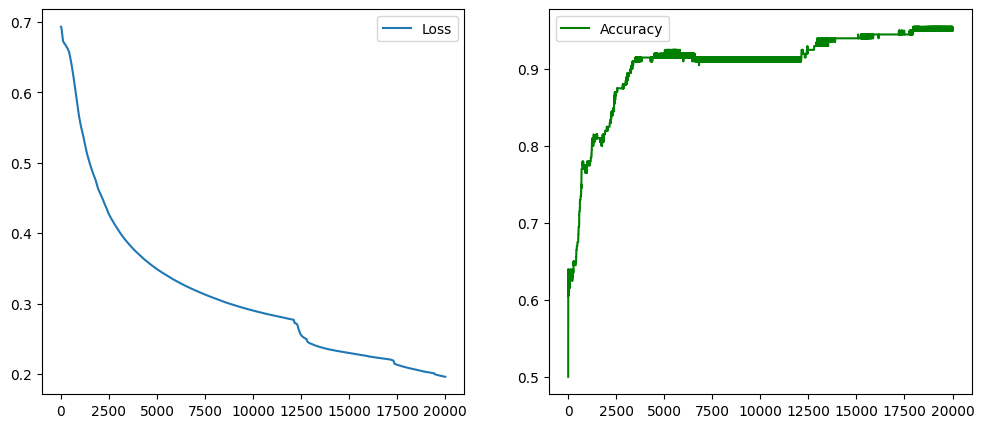

In [45]:
# Create dataset
X, y = spiral_data(samples=100, classes=2)
y = y.reshape(-1, 1)

# Model
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 1)
activation2 = Activation_Sigmoid()
loss_function = Loss_BinaryCrossentropy()
optimizer = Optimizer_Adam(decay=5e-7)

# Training
losses = []
accuracies = []
for epoch in range(20001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    data_loss = loss_function.calculate(activation2.output, y)
    reg_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)
    loss = data_loss + reg_loss
    losses.append(loss)

    preds = (activation2.output > 0.5) * 1
    acc = np.mean(preds == y)
    accuracies.append(acc)

    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Acc: {acc:.3f}, Loss: {loss:.3f}")

# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.legend()
plt.show()


In [46]:
# Final Validation
X_test, y_test = spiral_data(samples=100, classes=2)
y_test = y_test.reshape(-1, 1)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)

loss = loss_function.calculate(activation2.output, y_test)
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions == y_test)

print(f"Validation: Accuracy = {accuracy:.3f}, Loss = {loss:.3f}")


Validation: Accuracy = 0.940, Loss = 0.181
